In [153]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
import numpy as np
import torch as th

from src.data.comp_2d import GmmRadial

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data

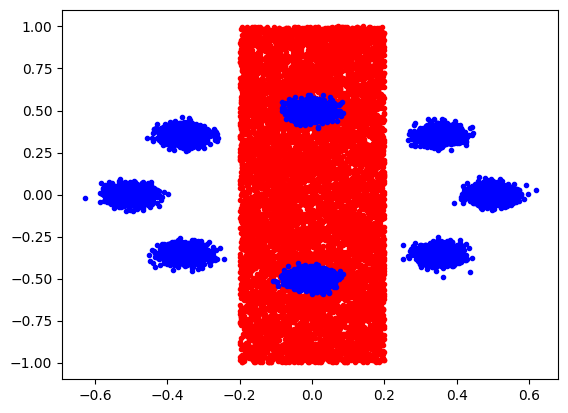

In [163]:
import numpy as np
import torch as th
from src.data.comp_2d import GmmRadial, Bar
import matplotlib.pyplot as plt

num_samples = 10_000
gmm_data = GmmRadial(8)
gmm_samples, _ = gmm_data.sample(num_samples)
bar_data = Bar()
bar_samples, _ = bar_data.sample(num_samples)

plt.plot(bar_samples[:, 0], bar_samples[:, 1], 'r.')
plt.plot(gmm_samples[:, 0], gmm_samples[:, 1], 'b.')

# Product composition

Given two unconditional score-parameterised diffusion models:
$$
\epsilon_\theta^{GMM}(x_t, t),\quad \epsilon_\theta^{Bar}(x_t, t)
$$
Trained separately on the two datasets above respectively.
Below are samples drawn from the reverse process of each model.

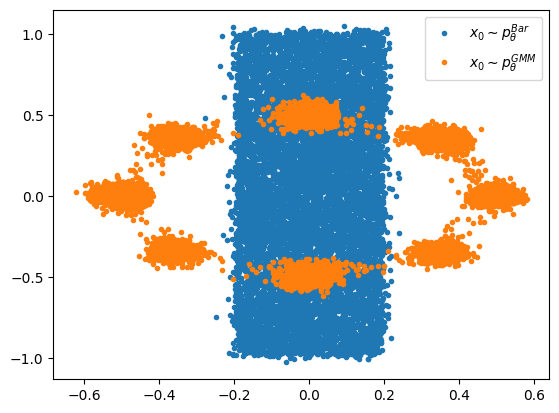

In [164]:
from pathlib import Path
import matplotlib.pyplot as plt
bar_xs = th.load(Path.cwd().parent / "results/comp_2d/bar_samples.th")
gmm_xs = th.load(Path.cwd().parent / "results/comp_2d/gmm_samples.th")

plt.plot(bar_xs[:, 0], bar_xs[:, 1], '.', label="$x_0 \sim p_\\theta^{Bar}$")
plt.plot(gmm_xs[:, 0], gmm_xs[:, 1], '.', label="$x_0 \sim p_\\theta^{GMM}$")
plt.legend()

## Sampling from product composition
To sample from the composed model, we compose a score
$$
\nabla_{x_t} \log p_\theta^{prod} = - \frac{1}{\sigma_t} \left( \epsilon_\theta^{GMM}(x_t, t) + \epsilon_\theta^{Bar}(x_t, t) \right).
$$

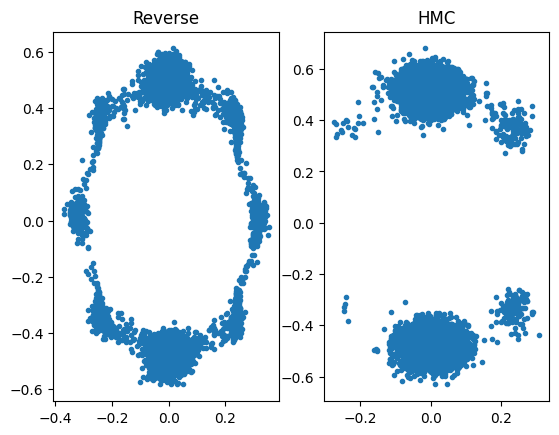

In [165]:
from pathlib import Path
import matplotlib.pyplot as plt
reverse_samples = th.load(Path.cwd().parent / "results/comp_2d/prod_samples_reverse.th")
hmc_samples = th.load(Path.cwd().parent / "results/comp_2d/prod_samples_hmc_without_rev.th")
_, (ax_rev, ax_hmc) = plt.subplots(1, 2)
ax_rev.plot(reverse_samples[:, 0], reverse_samples[:, 1], '.')
ax_rev.set_title("Reverse")
ax_hmc.plot(hmc_samples[:, 0], hmc_samples[:, 1], '.')
ax_hmc.set_title("HMC");

# Classifier-free guidance on 2D GMM

We denote the components in the GMM with a respective class. We train a classifier $p(y \mid x_t, t)$ and perform guided sampling. 

In [166]:
import numpy as np
import torch as th
from src.data.comp_2d import GmmRadial, Bar
import matplotlib.pyplot as plt
from src.model.comp_2d.classifier import Classifier, load_classifier
from src.utils.metrics import accuracy, hard_label_from_logit

num_samples = 10_000
T = 100
gmm_data = GmmRadial(8)
gmm_samples, labels = gmm_data.sample(num_samples)

params = Path.cwd().parent / "models/comp_2d/class_t_gmm.pt"
class_ = load_classifier(params, gmm_data.num_comp, "cpu")
t = th.ones((num_samples,)).long()
logits = class_(gmm_samples, t)
acc = accuracy(hard_label_from_logit(logits), labels)
print(f"Accuracy at t=0: {acc * 100:.2f}%")

Accuracy at t=0: 100.00%


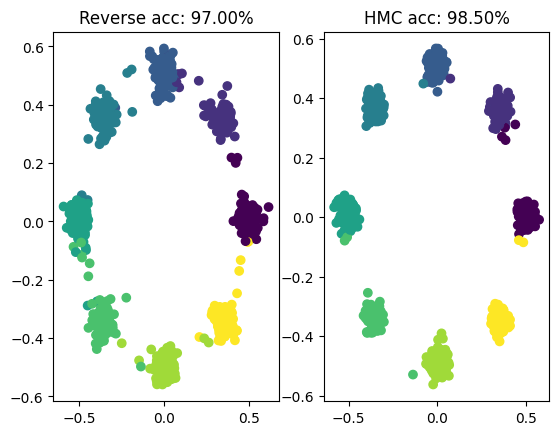

In [168]:
from torch.distributions.multivariate_normal import MultivariateNormal

def conditional_nll(gmm, samples, classes):
    cov = gmm.std**2 * th.eye(2)
    ll = 0.0
    for cl in th.arange(classes.max() + 1):
        mean = gmm.means[cl]
        cond_samples = samples[classes == cl, :]
        pdf = MultivariateNormal(loc=mean, covariance_matrix=cov)
        ll += pdf.log_prob(cond_samples).sum().item()
    num_samples = classes.size(0)
    return -ll / num_samples
    
res_dir = Path.cwd().parent / "results/comp_2d"
classes = th.load(res_dir / "guid_classes_gmm.th")
guid_samples = th.load(res_dir / "guid_samples_gmm.th")
hmc_guid_samples = th.load(res_dir / "hmc_guid_samples_gmm.th")
classes_hmc = th.load(res_dir / "hmc_guid_classes_gmm.th")

assert th.allclose(classes, classes_hmc)
# Classification accuracy
t = th.ones((classes.size(0),)).long()
logits = class_(guid_samples, t)
labels_rev = hard_label_from_logit(logits)
acc_rev = accuracy(labels_rev, classes)
logits = class_(hmc_guid_samples, t)
labels_hmc = hard_label_from_logit(logits)
acc_hmc = accuracy(labels_hmc, classes)

# Sampling NLL
marginal_nll_rev = gmm_data.nll(guid_samples)
marginal_nll_hmc = gmm_data.nll(hmc_guid_samples)
cond_nll_rev = gmm_data.conditional_nll(guid_samples, classes)
cond_nll_hmc = gmm_data.conditional_nll(hmc_guid_samples, classes)

_, [ax_guid, ax_hmc] = plt.subplots(1, 2)
ax_guid.scatter(guid_samples[:, 0], guid_samples[:, 1], c=classes)
ax_guid.set_title(f"Reverse acc: {acc_rev * 100:.2f}%")
ax_hmc.scatter(hmc_guid_samples[:, 0], hmc_guid_samples[:, 1], c=classes)
ax_hmc.set_title(f"HMC acc: {acc_hmc * 100:.2f}%");

# error_inds = classes == labels_rev
# _, [ax_guid, ax_hmc] = plt.subplots(1, 2)
# ax_guid.scatter(guid_samples[:, 0], guid_samples[:, 1], c=error_inds)
# ax_guid.set_title(f"Reverse acc: {acc_rev * 100:.2f}%")
# error_inds = classes == labels_hmc
# ax_hmc.scatter(hmc_guid_samples[:, 0], hmc_guid_samples[:, 1], c=error_inds)
# ax_hmc.set_title(f"HMC acc: {acc_hmc * 100:.2f}%");

#print(f"Reverse:\n\t Acc: {acc_rev*100:.2f}%\t Marginal NLL: {marginal_nll_rev:.4f}\t Cond. NLL: {cond_nll_rev:.4f}")
#print(f"HMC:\n\t Acc: {acc_hmc*100:.2f}%\t Marginal NLL: {marginal_nll_hmc:.4f}\t Cond. NLL: {cond_nll_hmc:.4f}")

# Metrics

NB: Only one simulation (1000 samples)
|            | Acc. [%] | Cond. NLL | Marg. NLL |
|------------|----------|-------------|-----------|
| Reverse    | 97.0     | -2.5835     | -1.6685   |
| HMC        | 98.5     | -3.5724     | -2.2974   |